<a href="https://colab.research.google.com/github/rvalienter90/UCF/blob/master/CAP-5610_MACHINE%20LEARNING/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RODOLFO VALIENTE ROMERO**



# HW 3

** *Code is based on course notes and was used code from the Colab examples**

The goal of this homework is to learn how to leverage pretrained convnets and to use some visualization techniques.
You will work with the data set *cats vs dogs* and use the pretrained convnet VGG19.

Experiment with different classifiers, trying to maximize the validation accuracy. You only need to show one classifier.

---
**Problem 1**

Do feature extraction with data augmentation.

**Problem 2**

Do fine-tuning with data augmentation. 

**Problem 3**

Visualize heatmaps of class activation for the the model obtained in Problem 2.

**Problem 4**

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.


## Loading the image data  data set and functions

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [0]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import layers
from keras import models
from keras.applications import VGG16
from keras import layers
from keras import models
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from google.colab import files

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 13:23:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   119MB/s    in 0.5s    

2019-04-17 13:23:03 (119 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
def feature_extractio_data_augmentation(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20):
  # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base
  conv_base.trainable = False

  # Concatenate the convolutional base and densely connected layers
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  # no dropout
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  return model,history


def fine_tuning_data_augmentation(train_dir,validation_dir,epochs=20,lr=2e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' ):
  # Load the convolutional base
  conv_base = VGG16(
      weights='imagenet', 
      include_top=False, 
      input_shape=(150, 150, 3))

  # Freeze the convolutional base

  conv_base.trainable = True

  set_trainable = False
  for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
      
      
  # Load pre-train model
  model = load_model(model_fname)
  
  model.summary()
  
  # data augmentation

  train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=20,
      class_mode='binary')

  # compile model

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers.RMSprop(lr=lr), 
      metrics=['acc'])

  # train

  history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50
  )
  
  val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
  print("Validation loss:", val_loss)
  print("Validation accuracy:", val_acc)
  
  return model,history



def model_plot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # training and validation accuracy

  plt.plot(epochs, acc, 'bo', label='training acc')
  plt.plot(epochs, val_acc, 'b', label='validation acc')
  plt.title('training and validation accuracy')
  plt.legend()

  plt.figure()

  # training and validation loss

  plt.plot(epochs, loss, 'bo', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('training and validation loss')
  plt.legend()

  plt.show()


###Explore data

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
print(train_cat_fnames[:10])
print(train_cat_fnames[-10:])
print()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])
print(train_dog_fnames[-10:])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['cat.990.jpg', 'cat.991.jpg', 'cat.992.jpg', 'cat.993.jpg', 'cat.994.jpg', 'cat.995.jpg', 'cat.996.jpg', 'cat.997.jpg', 'cat.998.jpg', 'cat.999.jpg']

['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']
['dog.990.jpg', 'dog.991.jpg', 'dog.992.jpg', 'dog.993.jpg', 'dog.994.jpg', 'dog.995.jpg', 'dog.996.jpg', 'dog.997.jpg', 'dog.998.jpg', 'dog.999.jpg']


In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print()
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000

total validation cat images: 500
total validation dog images: 500


###Display some images


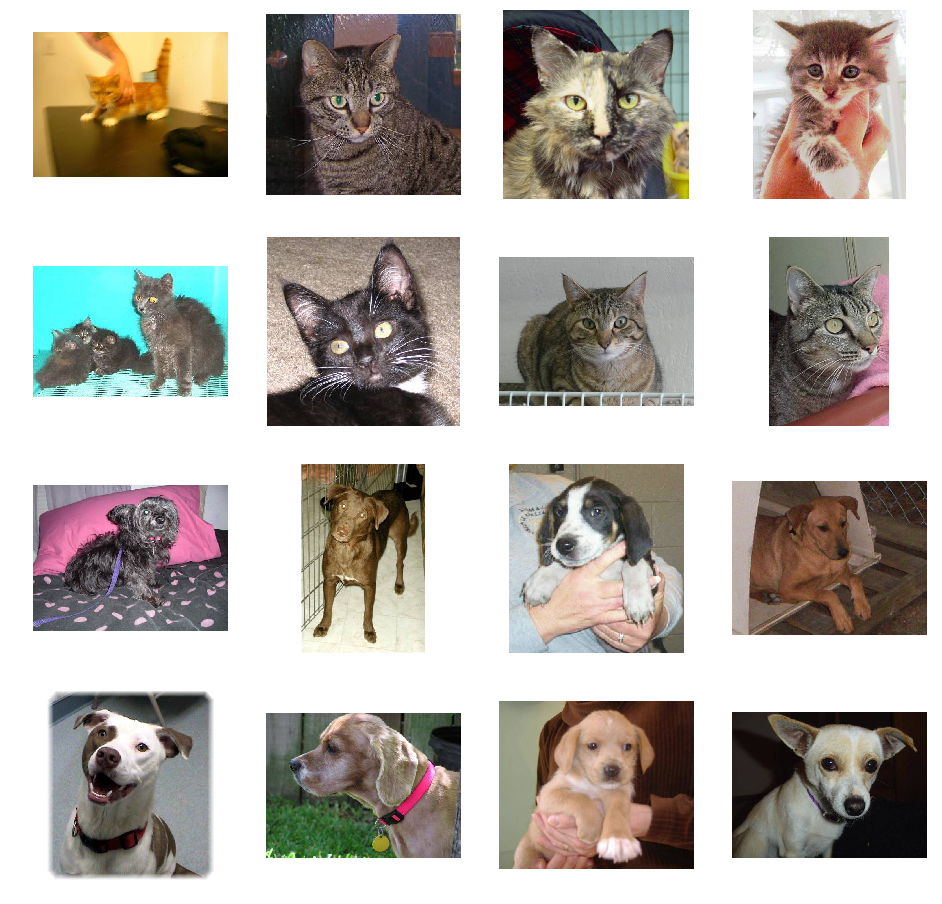

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Problem 1

Do feature extraction with data augmentation.


### Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. We will use data augmentation. We will not use dropout.

### Build network with VGG16 convolution base and custom densely connected layers


In [12]:
# Load the convolutional base
conv_base = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

# Freeze the convolutional base
conv_base.trainable = False

# Concatenate the convolutional base and densely connected layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# no dropout
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## Final Solution 

In [20]:
model,history= feature_extractio_data_augmentation(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 278ms/step - loss: 0.6370 - acc: 0.6470 - val_loss: 0.5458 - val_acc: 0.7690
Epoch 2/30
100/100 [===============

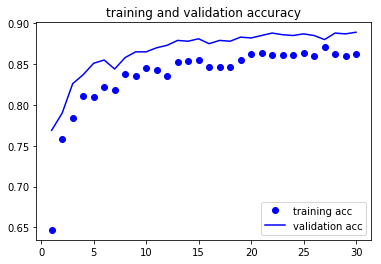

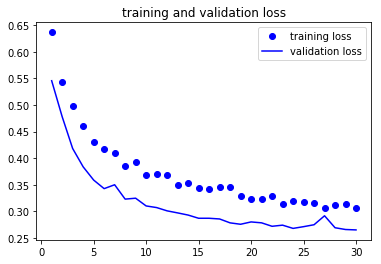

In [22]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p1.h5' 
model.save(model_fname)


In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

### Train the model end to end with frozen convolutional base

In [14]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 30s 298ms/step - loss: 0.5901 - acc: 0.6840 - val_loss: 0.4552 - val_acc: 0.8050
Epoch 2/20
100/100 [==============================] - 25s 252ms/step - loss: 0.4908 - acc: 0.7770 - val_loss: 0.3779 - val_acc: 0.8380
Epoch 3/20
100/100 [==============================] - 25s 254ms/step - loss: 0.4284 - acc: 0.8025 - val_loss: 0.3463 - val_acc: 0.8530
Epoch 4/20
100/100 [==============================] - 25s 254ms/step - loss: 0.3964 - acc: 0.8305 - val_loss: 0.3196 - val_acc: 0.8620
Epoch 5/20
100/100 [==============================] - 25s 255ms/step - loss: 0.3880 - acc: 0.8345 - val_loss: 0.3070 - val_acc: 0.8690
Epoch 6/20
100/100 [==============================] - 25s 255ms/step - loss: 0.3688 - acc: 0.8365 - val_loss: 0.2975 - val_acc: 0.8630
Epoch 7/20
100/100 [==============================] - 25s 

### Display curves of loss and accuracy during training

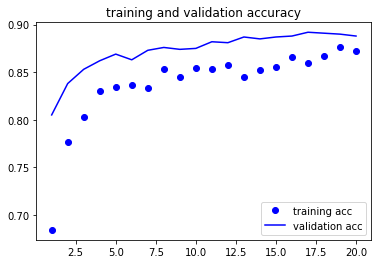

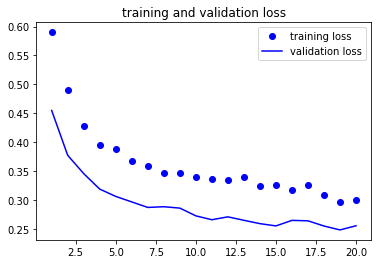

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Problem 2

Do fine-tuning with data augmentation. 

### Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [29]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 28s 277ms/step - loss: 0.3041 - acc: 0.8710 - val_loss: 0.2808 - val_acc: 0.8900
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3034 - acc: 0.8616

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 58460, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

100/100 [==============================] - 25s 255ms/step - loss: 0.3034 - acc: 0.8620 - val_loss: 0.2586 - val_acc: 0.8850
Epoch 3/10
100/100 [==============================] - 25s 254ms/step - loss: 0.3149 - acc: 0.8680 - val_loss: 0.2554 - val_acc: 0.8810
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2992 - acc: 0.8670 - val_loss: 0.2494 - val_acc: 0.9000
Epoch 5/10
100/100 [==============================] - 25s 254ms/step - loss: 0.3050 - acc: 0.8670 - val_loss: 0.2843 - val_acc: 0.8760
Epoch 6/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2967 - acc: 0.8735 - val_loss: 0.2442 - val_acc: 0.9050
Epoch 7/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2964 - acc: 0.8720 - val_loss: 0.2749 - val_acc: 0.8900
Epoch 8/10
100/100 [==============================] - 25s 254ms/step - loss: 0.2976 - acc: 0.8705 - val_loss: 0.2726 - val_acc: 0.8820
Epoch 9/10
100/100 [==============================] - 25s 255ms/st

### Display learning curves during fine-tuning

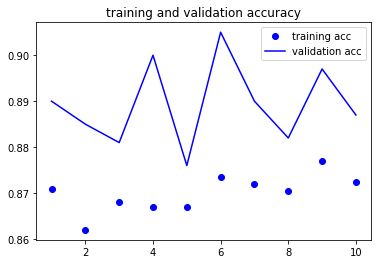

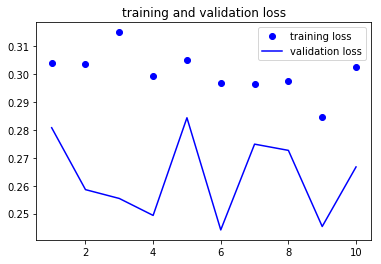

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Final Solution 

In [32]:
model,history= fine_tuning_data_augmentation(train_dir,validation_dir,epochs=30,lr=1e-5,batch_size=20,model_fname= 'cats_and_dogs_p1.h5' )

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 47s 470ms/step - loss: 0.3032 - acc: 0.8700 - val_loss: 0.1927 - val_acc: 0.9230
Epoch 2/30
100/100 [=======================

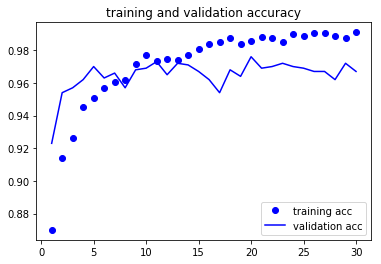

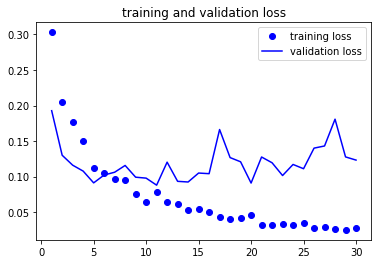

In [33]:
model_plot(history)

In [0]:
model_fname = 'cats_and_dogs_p2.h5' 
model.save(model_fname)

In [0]:
with open(model_fname, 'r') as f:
  files.download(model_fname)

## Problem 3

Visualize heatmaps of class activation for the the model obtained in Problem 2.


## Problem 4

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.